# Data processing and loading

In [1]:
# Importing required libraries
import pandas as pd
import os

# Define the directories for plantvillage and plantdoc
base_dir = r'C:\Users\bheja\OneDrive\Desktop\Dataset'
plant_vil_dir = os.path.join(base_dir, 'plantvillage')
plant_doc_dir = os.path.join(base_dir, 'plantdoc')

# Load the CSV files
train_csv_path = os.path.join(base_dir, 'PV_train.csv')
test_seen_csv_path = os.path.join(base_dir, 'PV_test_seen.csv')
test_unseen_csv_path = os.path.join(base_dir, 'PV_test_unseen.csv')
doc_unseen_csv_path = os.path.join(base_dir, 'PD_test_unseen.csv')

# Read the CSV files into pandas DataFrames
train_data = pd.read_csv(train_csv_path, header=None, names=["image_name", "crop_class", "disease_class"])
test_seen_data = pd.read_csv(test_seen_csv_path, header=None, names=["image_name", "crop_class", "disease_class"])
test_unseen_data = pd.read_csv(test_unseen_csv_path, header=None, names=["image_name", "crop_class", "disease_class"])
doc_unseen_data = pd.read_csv(doc_unseen_csv_path, header=None, names=["image_name", "crop_class", "disease_class"])

In [2]:
# Print the data types of the columns in the DataFrame
print("Data types of columns in train_data:")
print(train_data.dtypes)

# Print the data types for the specific columns (crop_class and disease_class)
print("\nData type of 'crop_class' column:", train_data["crop_class"].dtype)
print("Data type of 'disease_class' column:", train_data["disease_class"].dtype)

Data types of columns in train_data:
image_name       object
crop_class        int64
disease_class     int64
dtype: object

Data type of 'crop_class' column: int64
Data type of 'disease_class' column: int64


# Crop Class

## Balancing the dataset

In [2]:
# Dataset Balancing for Crop Classes

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract the crop class labels from the training data
y_crop = train_data['crop_class'].astype(str).values  # Convert to string since class_weight requires classes as strings or integers

# Calculate class weights for the crop classes
crop_classes = np.unique(y_crop)  # Get unique crop classes
class_weights_crop = compute_class_weight('balanced', classes=crop_classes, y=y_crop)
class_weights_crop_dict = dict(zip(crop_classes, class_weights_crop))

# Print the class weights for crop classes
print("Class Weights for Crop Classes:")
print(class_weights_crop_dict)


Class Weights for Crop Classes:
{'0': 1.2648890618917867, '1': 2.785285714285714, '10': 2.785285714285714, '11': 1.8531508411747932, '12': 2.1116646810354163, '13': 0.19303387028108077, '2': 1.6870295059271436, '3': 0.8999307639049158, '4': 0.8836566352429297, '5': 0.6386805123333442, '6': 1.326958415572041, '7': 2.198331266208141, '8': 1.6307293409166945, '9': 13.390796703296703}


## Image Preprocessing

In [5]:
pip install opencv-python


   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---- ----------------------------------- 3.9/38.8 MB 23.5 MB/s eta 0:00:02
   ----------- ---------------------------- 11.5/38.8 MB 31.4 MB/s eta 0:00:01
   -------------------- ------------------- 19.9/38.8 MB 34.0 MB/s eta 0:00:01
   ---------------------------- ----------- 27.8/38.8 MB 35.2 MB/s eta 0:00:01
   ------------------------------------ --- 35.7/38.8 MB 36.0 MB/s eta 0:00:01
   ---------------------------------------- 38.8/38.8 MB 34.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


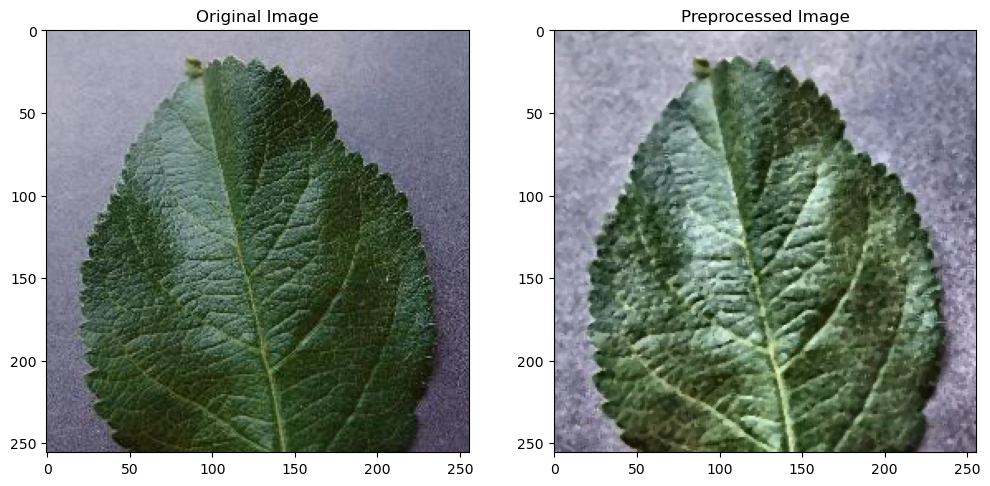

In [3]:
import cv2
import numpy as np
import os

# Function for image pre-processing
def preprocess_image(image_path):
    # Read the image in RGB format
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert the image from RGB to Lab color space
    image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)
    
    # Apply CLAHE to the L channel
    l_channel, a_channel, b_channel = cv2.split(image_lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_channel = clahe.apply(l_channel)
    
    # Merge the L, a, b channels and convert back to RGB color space
    image_lab = cv2.merge((l_channel, a_channel, b_channel))
    enhanced_image = cv2.cvtColor(image_lab, cv2.COLOR_Lab2RGB)
    
    # Apply Adaptive Median Filter to remove noise
    enhanced_image_filtered = cv2.medianBlur(enhanced_image, 3)
    
    return enhanced_image_filtered

# Test the preprocessing function on a sample image
sample_image_path = os.path.join(plant_vil_dir, train_data.iloc[0]['image_name'])
processed_image = preprocess_image(sample_image_path)

# Display the original and preprocessed images for comparison
import matplotlib.pyplot as plt

original_image = cv2.imread(sample_image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title('Preprocessed Image')

plt.show()


## Generators

In [4]:
train_data["crop_class"] = train_data["crop_class"].astype(str)
test_seen_data["crop_class"] = test_seen_data["crop_class"].astype(str)
test_unseen_data["crop_class"] = test_unseen_data["crop_class"].astype(str)
doc_unseen_data["crop_class"] = doc_unseen_data["crop_class"].astype(str)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data augmentation generator for training
train_datagen_crop = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create data generator for testing --without augmentation, only rescale--
test_datagen_crop = ImageDataGenerator(rescale=1./255)

# Create the training data generator
train_generator_crop = train_datagen_crop.flow_from_dataframe(
    dataframe=train_data,
    directory=plant_vil_dir,
    x_col="image_name",
    y_col="crop_class",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Use the class indices from the training generator
classes_list = list(train_generator_crop.class_indices.keys())

# Use the same classes_list to ensure consistency in the testing generators
test_seen_generator_crop = test_datagen_crop.flow_from_dataframe(
    dataframe=test_seen_data,
    directory=plant_vil_dir,
    x_col="image_name",
    y_col="crop_class",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes_list,  # Using the same classes as training generator
    shuffle=False
)

test_unseen_generator_crop = test_datagen_crop.flow_from_dataframe(
    dataframe=test_unseen_data,
    directory=plant_vil_dir,
    x_col="image_name",
    y_col="crop_class",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes_list,  # Using the same classes as training generator
    shuffle=False
)

doc_unseen_generator_crop = test_datagen_crop.flow_from_dataframe(
    dataframe=doc_unseen_data,
    directory=plant_doc_dir,
    x_col="image_name",
    y_col="crop_class",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes_list,  # Using the same classes as training generator
    shuffle=False
)

# Verify the class indices for the data generators again -- :) I guess good practice
print("Class indices for training generator (Crop):", train_generator_crop.class_indices)
print("Class indices for testing generator (Seen Crop):", test_seen_generator_crop.class_indices)
print("Class indices for testing generator (Unseen Crop):", test_unseen_generator_crop.class_indices)
print("Class indices for testing generator (Doc Unseen Crop):", doc_unseen_generator_crop.class_indices)


Found 38994 validated image filenames belonging to 14 classes.
Found 10279 validated image filenames belonging to 14 classes.
Found 216 validated image filenames belonging to 14 classes.
Found 71 validated image filenames belonging to 14 classes.
Class indices for training generator (Crop): {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13}
Class indices for testing generator (Seen Crop): {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13}
Class indices for testing generator (Unseen Crop): {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13}
Class indices for testing generator (Doc Unseen Crop): {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13}


## Training

In [6]:
# Convert keys of class_weights_crop_dict to integers
class_weights_crop_dict = {int(k): v for k, v in class_weights_crop_dict.items()}

# Print the updated class weights for crop classes
print("Updated Class Weights for Crop Classes:")
print(class_weights_crop_dict)

Updated Class Weights for Crop Classes:
{0: 1.2648890618917867, 1: 2.785285714285714, 10: 2.785285714285714, 11: 1.8531508411747932, 12: 2.1116646810354163, 13: 0.19303387028108077, 2: 1.6870295059271436, 3: 0.8999307639049158, 4: 0.8836566352429297, 5: 0.6386805123333442, 6: 1.326958415572041, 7: 2.198331266208141, 8: 1.6307293409166945, 9: 13.390796703296703}


### Resnet50v2

In [15]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np

# Load pre-trained ResNet50V2 model + higher level layers
# We're using the 'imagenet' weights and excluding the top layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the initial layers to retain the pre-trained features
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.4)(x)  # Add Dropout to prevent overfitting
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.4)(x)  # Add Dropout to prevent overfitting
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.4)(x)  # Add Dropout to prevent overfitting
output = Dense(len(classes_list), activation='softmax')(x)  # Output layer with number of crop classes

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a higher learning rate
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# Define callbacks for training
checkpoint_resnet = ModelCheckpoint(filepath=r'C:\Users\bheja\OneDrive\Desktop\models\resnet50v2_crop.h5',
                                    monitor='val_loss',
                                    save_best_only=True,
                                    save_weights_only=False,
                                    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss to decide when to reduce the learning rate
    factor=0.5,                  # Reduce learning rate by a factor of 0.5
    patience=3,                  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,                 # Lower bound on the learning rate to prevent it from going too low
    verbose=1                    # Prints a message when learning rate is reduced
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the training and validation generators
history_resnet = model.fit(
    train_generator_crop,
    epochs=50,  # Training with transfer learning so not going for 100 as the earliar models
    batch_size=32,
    validation_data=test_seen_generator_crop,
    class_weight=class_weights_crop_dict,  # Use class weights for imbalance
    callbacks=[reduce_lr, early_stop, checkpoint_resnet]
)


Epoch 1/50
1219/1219 [==============================] - ETA: 0s - loss: 0.9984 - accuracy: 0.7934 - precision_2: 0.8903 - recall_2: 0.7279 - auc_2: 0.9738
Epoch 1: val_loss improved from inf to 0.17002, saving model to C:\Users\bheja\OneDrive\Desktop\models\resnet50v2_crop.h5
1219/1219 [==============================] - 950s 767ms/step - loss: 0.9984 - accuracy: 0.7934 - precision_2: 0.8903 - recall_2: 0.7279 - auc_2: 0.9738 - val_loss: 0.1700 - val_accuracy: 0.9552 - val_precision_2: 0.9637 - val_recall_2: 0.9498 - val_auc_2: 0.9963 - lr: 0.0010
Epoch 2/50
1219/1219 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.9356 - precision_2: 0.9526 - recall_2: 0.9194 - auc_2: 0.9942
Epoch 2: val_loss did not improve from 0.17002
1219/1219 [==============================] - 863s 708ms/step - loss: 0.2970 - accuracy: 0.9356 - precision_2: 0.9526 - recall_2: 0.9194 - auc_2: 0.9942 - val_loss: 0.2745 - val_accuracy: 0.9302 - val_precision_2: 0.9414 - val_recall_2: 0.9226 - 

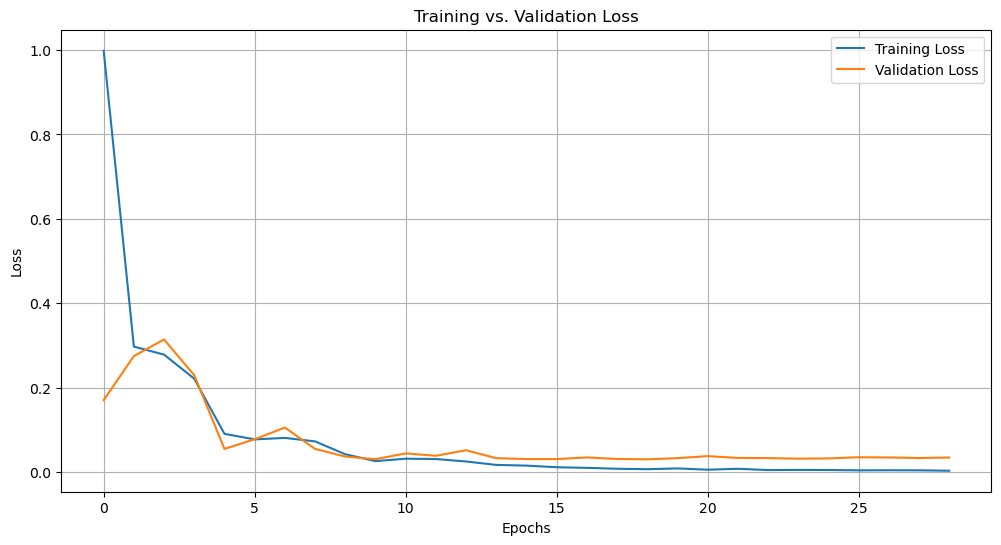

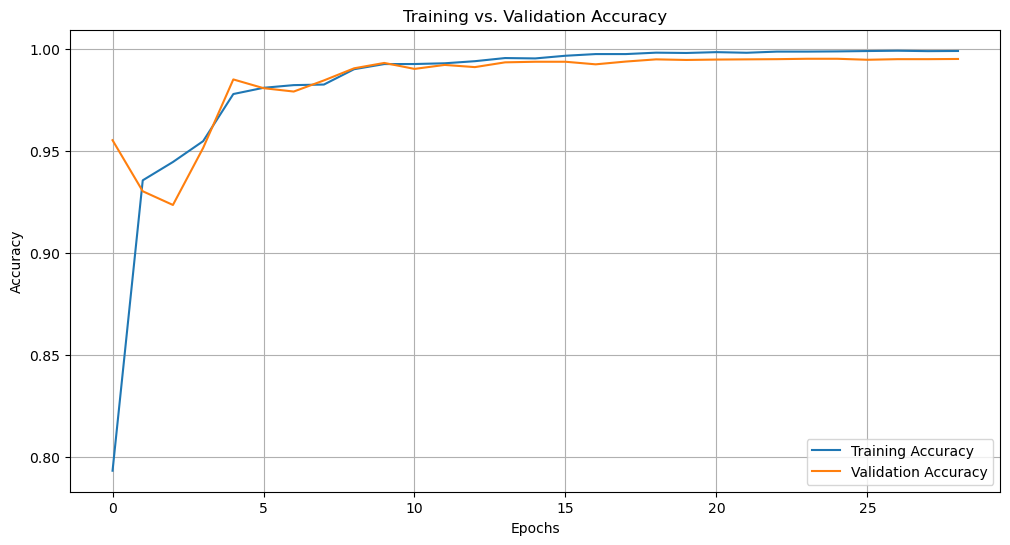

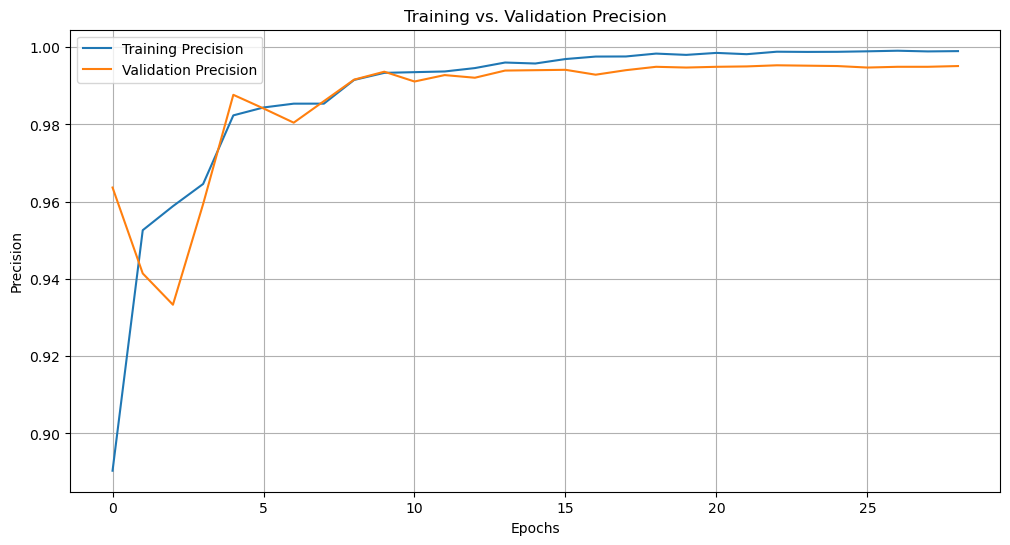

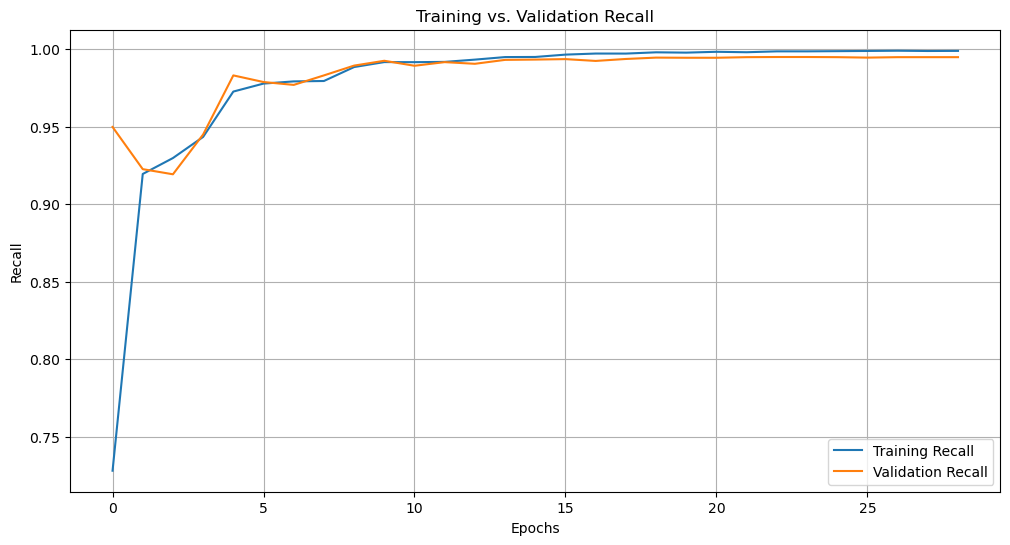

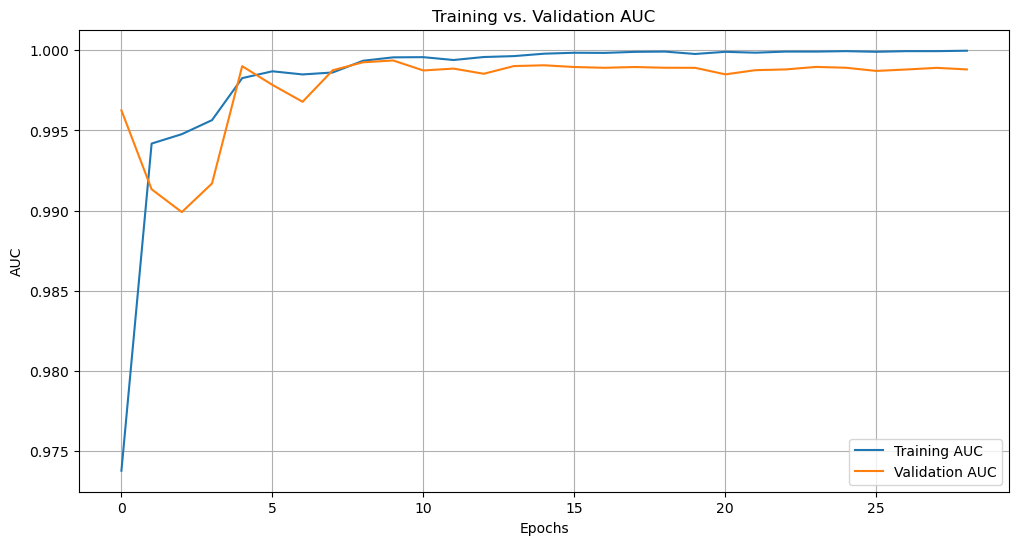

In [20]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Precision
plt.figure(figsize=(12, 6))
plt.plot(history_resnet.history['precision_2'], label='Training Precision')
plt.plot(history_resnet.history['val_precision_2'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training vs. Validation Precision')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Recall
plt.figure(figsize=(12, 6))
plt.plot(history_resnet.history['recall_2'], label='Training Recall')
plt.plot(history_resnet.history['val_recall_2'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training vs. Validation Recall')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation AUC
plt.figure(figsize=(12, 6))
plt.plot(history_resnet.history['auc_2'], label='Training AUC')
plt.plot(history_resnet.history['val_auc_2'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid()
plt.show()


### DenseNet121

In [14]:
from tensorflow.keras.applications import DenseNet121  # Use a smaller model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC

# Load DenseNet121 with pre-trained ImageNet weights (using a smaller model)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the initial layers to reduce memory usage
for layer in base_model.layers[:300]:  # Freeze more layers to reduce computational load
    layer.trainable = False

# Custom layers on top of DenseNet121
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(classes_list), activation='softmax')(x)

# Define and compile the DenseNet121 model
densenet_model = Model(inputs=base_model.input, outputs=output)
densenet_model.compile(optimizer=Adam(learning_rate=1e-3),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(), Recall(), AUC()])

# Callbacks for DenseNet121
checkpoint_densenet = ModelCheckpoint(filepath=r'C:\Users\bheja\OneDrive\Desktop\models\densenet121_crop.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the DenseNet121 model with a reduced batch size
history_densenet = densenet_model.fit(
    train_generator_crop,
    epochs=50,
    validation_data=test_seen_generator_crop,
    #batch_size=8,  # Reduce the batch size if "Resource exhausted"
    class_weight=class_weights_crop_dict,
    callbacks=[reduce_lr, early_stop, checkpoint_densenet]
)


29084464/29084464 [==============================] - 3s 0us/step
Epoch 1/50
1219/1219 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.9331 - precision_5: 0.9515 - recall_5: 0.9204 - auc_5: 0.9935
Epoch 1: val_loss improved from inf to 0.10520, saving model to C:\Users\bheja\OneDrive\Desktop\models\densenet121_crop.h5
1219/1219 [==============================] - 1010s 820ms/step - loss: 0.3372 - accuracy: 0.9331 - precision_5: 0.9515 - recall_5: 0.9204 - auc_5: 0.9935 - val_loss: 0.1052 - val_accuracy: 0.9686 - val_precision_5: 0.9719 - val_recall_5: 0.9667 - val_auc_5: 0.9973 - lr: 0.0010
Epoch 2/50
1219/1219 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9748 - precision_5: 0.9791 - recall_5: 0.9701 - auc_5: 0.9976
Epoch 2: val_loss improved from 0.10520 to 0.09056, saving model to C:\Users\bheja\OneDrive\Desktop\models\densenet121_crop.h5
1219/1219 [==============================] - 750s 615ms/step - loss: 0.1204 - accuracy: 0.9748 - p

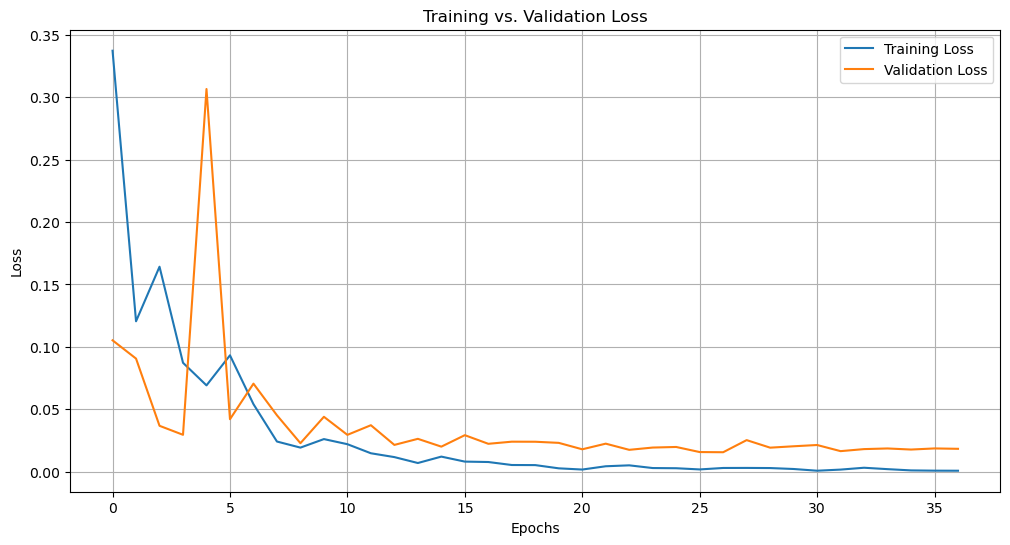

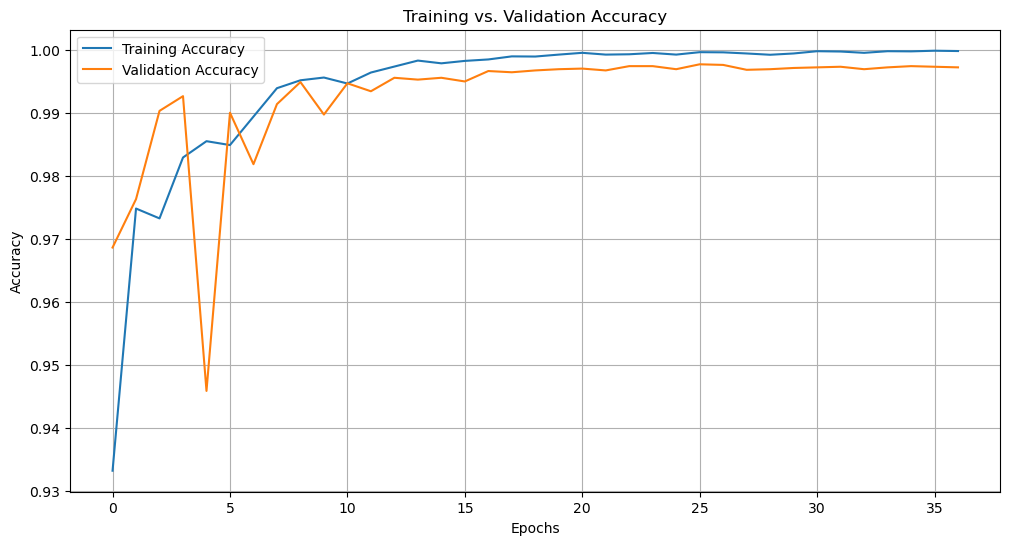

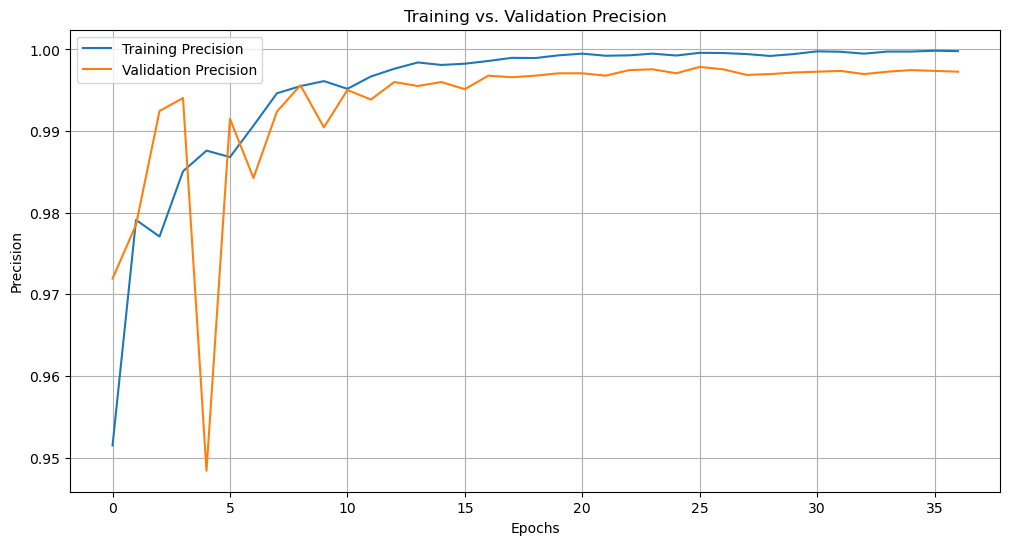

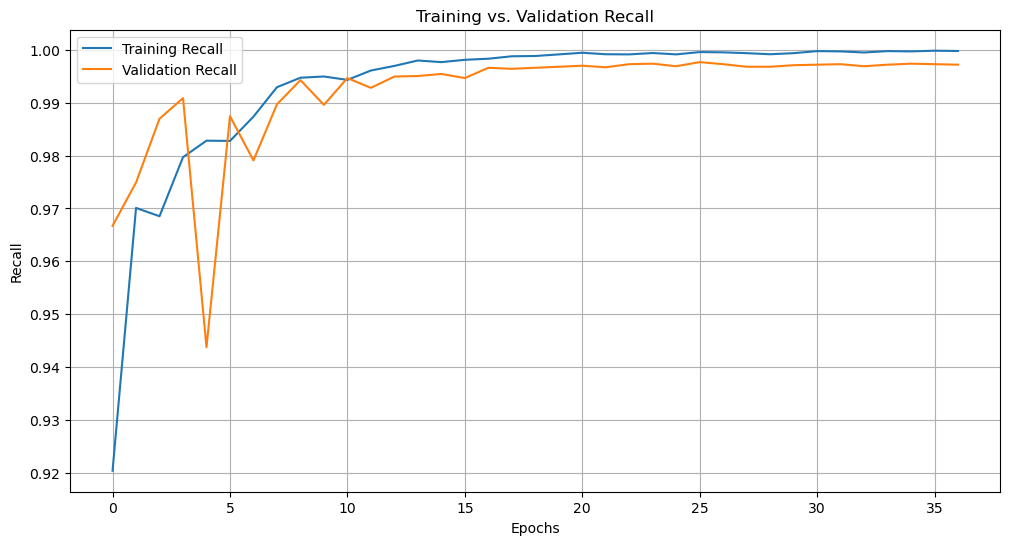

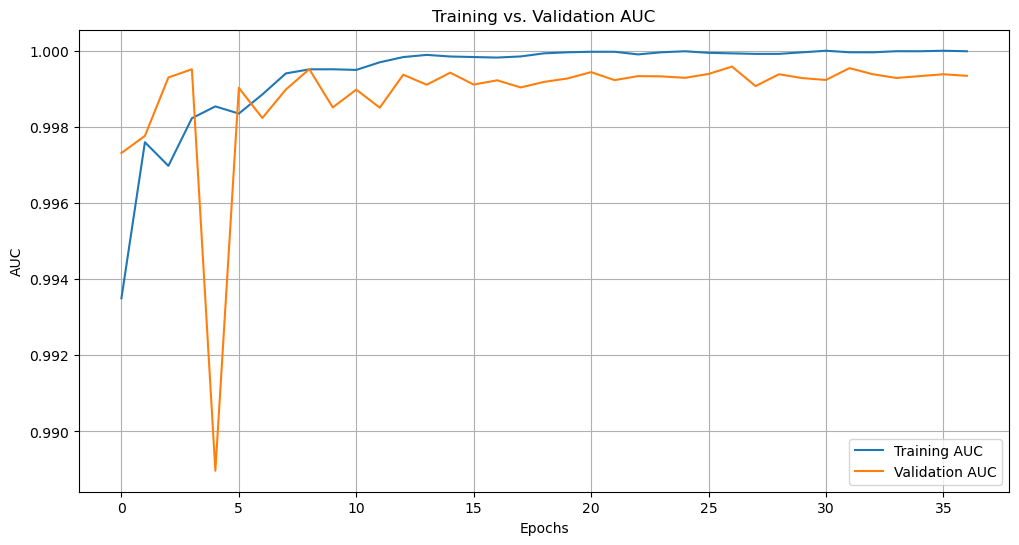

In [20]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Precision
plt.figure(figsize=(12, 6))
plt.plot(history_densenet.history['precision_5'], label='Training Precision')
plt.plot(history_densenet.history['val_precision_5'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training vs. Validation Precision')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Recall
plt.figure(figsize=(12, 6))
plt.plot(history_densenet.history['recall_5'], label='Training Recall')
plt.plot(history_densenet.history['val_recall_5'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training vs. Validation Recall')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation AUC
plt.figure(figsize=(12, 6))
plt.plot(history_densenet.history['auc_5'], label='Training AUC')
plt.plot(history_densenet.history['val_auc_5'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid()
plt.show()


In [19]:
# Print the keys of the training history
print(history_densenet.history.keys())


dict_keys(['loss', 'accuracy', 'precision_5', 'recall_5', 'auc_5', 'val_loss', 'val_accuracy', 'val_precision_5', 'val_recall_5', 'val_auc_5', 'lr'])


### EfficientNetB0 ---- Did not run (Resource exhausted) -- laptop gpu rtx 3050

In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout  # Add GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC


# Load EfficientNetB0 with pre-trained ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Custom layers on top of EfficientNetB0
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(classes_list), activation='softmax')(x)

# Define and compile the EfficientNetB0 model
efficientnet_model = Model(inputs=base_model.input, outputs=output)
efficientnet_model.compile(optimizer=Adam(learning_rate=1e-3),
                           loss='categorical_crossentropy',
                           metrics=['accuracy', Precision(), Recall(), AUC()])

# Callbacks for EfficientNetB0
checkpoint_efficientnet = ModelCheckpoint(filepath=r'C:\Users\bheja\OneDrive\Desktop\models\efficientb0_crop.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the EfficientNetB0 model
history_efficientnet = efficientnet_model.fit(
    train_generator_crop,
    epochs=50,
    batch_size=8,  # cos Resource Exhuasted
    validation_data=test_seen_generator_crop,
    class_weight=class_weights_crop_dict,
    callbacks=[reduce_lr, early_stop, checkpoint_efficientnet]
)


Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model_9/block2b_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\bheja\.conda\envs\mysha\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\bheja\.conda\envs\mysha\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\bheja\.conda\envs\mysha\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\bheja\.conda\envs\mysha\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\bheja\.conda\envs\mysha\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\bheja\AppData\Local\Temp\ipykernel_42188\1691588618.py", line 34, in <module>
      history_efficientnet = efficientnet_model.fit(
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\bheja\.conda\envs\mysha\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_9/block2b_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,144,56,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_9/block2b_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_178940]

# Disease model

## Balancing the data

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract the disease class labels from the training data
y_disease = train_data['disease_class'].astype(str).values  # Convert to string since class_weight requires classes as strings or integers

# Calculate class weights for the disease classes
disease_classes = np.unique(y_disease)  # Get unique disease classes
class_weights_disease = compute_class_weight('balanced', classes=disease_classes, y=y_disease)
class_weights_disease_dict = dict(zip(disease_classes, class_weights_disease))

# Print the class weights for disease classes
print("Class Weights for Disease Classes:")
print(class_weights_disease_dict)

Class Weights for Disease Classes:
{'0': 0.22542881423541858, '1': 3.7286288009179573, '10': 0.4257870082222295, '11': 0.5218822773628844, '12': 1.1165707413452453, '13': 0.7976190476190477, '14': 1.994475985883075, '15': 2.417782738095238, '16': 1.2753139717425432, '17': 1.415287456445993, '18': 1.6345573440643864, '19': 0.43062549695202756, '2': 1.3573517126148704, '20': 6.04839460214053, '3': 8.44025974025974, '4': 0.7575916535524858, '5': 4.539993014320642, '6': 1.9463911350703804, '7': 2.326888650196921, '8': 1.6895879370856624, '9': 2.2425810904071772}


## image processing (run if kernel restarted)

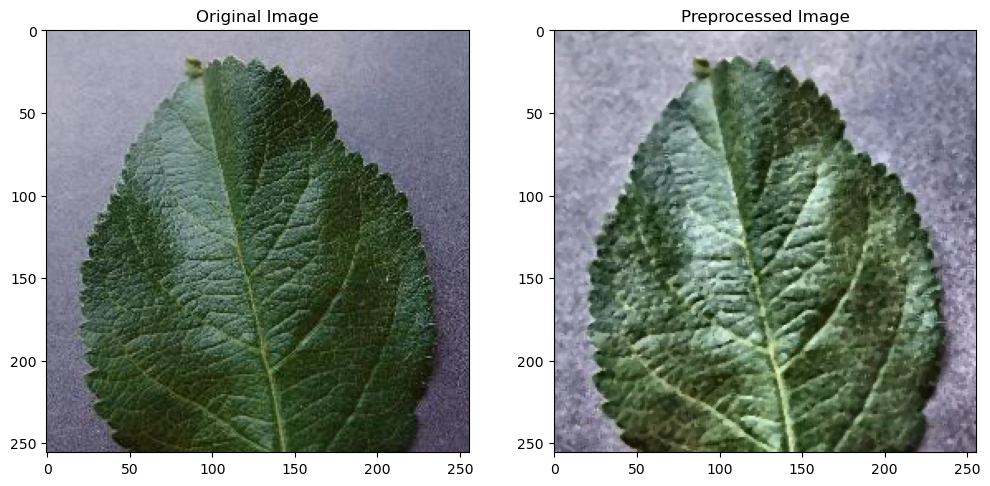

In [22]:
import cv2
import numpy as np
import os

# Function for image pre-processing
def preprocess_image(image_path):
    # Read the image in RGB format
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert the image from RGB to Lab color space
    image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)
    
    # Apply CLAHE to the L channel
    l_channel, a_channel, b_channel = cv2.split(image_lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_channel = clahe.apply(l_channel)
    
    # Merge the L, a, b channels and convert back to RGB color space
    image_lab = cv2.merge((l_channel, a_channel, b_channel))
    enhanced_image = cv2.cvtColor(image_lab, cv2.COLOR_Lab2RGB)
    
    # Apply Adaptive Median Filter to remove noise
    enhanced_image_filtered = cv2.medianBlur(enhanced_image, 3)
    
    return enhanced_image_filtered

# Test the preprocessing function on a sample image
sample_image_path = os.path.join(plant_vil_dir, train_data.iloc[0]['image_name'])
processed_image = preprocess_image(sample_image_path)

# Display the original and preprocessed images for comparison
import matplotlib.pyplot as plt

original_image = cv2.imread(sample_image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image_rgb)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title('Preprocessed Image')

plt.show()

## Generators

In [23]:
train_data["disease_class"] = train_data["disease_class"].astype(str)
test_seen_data["disease_class"] = test_seen_data["disease_class"].astype(str)
test_unseen_data["disease_class"] = test_unseen_data["disease_class"].astype(str)
doc_unseen_data["disease_class"] = doc_unseen_data["disease_class"].astype(str)



In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data augmentation generator for training
train_datagen_disease = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create data generator for testing --without augmentation, only rescale--
test_datagen_disease = ImageDataGenerator(rescale=1./255)

# Create the training data generator for disease classes
train_generator_disease = train_datagen_disease.flow_from_dataframe(
    dataframe=train_data,
    directory=plant_vil_dir,
    x_col="image_name",
    y_col="disease_class",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Use the class indices from the training generator
classes_list_disease = list(train_generator_disease.class_indices.keys())

# Use the same classes_list_disease to ensure consistency in the testing generators
test_seen_generator_disease = test_datagen_disease.flow_from_dataframe(
    dataframe=test_seen_data,
    directory=plant_vil_dir,
    x_col="image_name",
    y_col="disease_class",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes_list_disease,  # Using the same classes as training generator
    shuffle=False
)

test_unseen_generator_disease = test_datagen_disease.flow_from_dataframe(
    dataframe=test_unseen_data,
    directory=plant_vil_dir,
    x_col="image_name",
    y_col="disease_class",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes_list_disease,  # Using the same classes as training generator
    shuffle=False
)

doc_unseen_generator_disease = test_datagen_disease.flow_from_dataframe(
    dataframe=doc_unseen_data,
    directory=plant_doc_dir,
    x_col="image_name",
    y_col="disease_class",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=classes_list_disease,  # Using the same classes as training generator
    shuffle=False
)

# Verify the class indices for the data generators again
print("Class indices for training generator (Disease):", train_generator_disease.class_indices)
print("Class indices for testing generator (Seen Disease):", test_seen_generator_disease.class_indices)
print("Class indices for testing generator (Unseen Disease):", test_unseen_generator_disease.class_indices)
print("Class indices for testing generator (Doc Unseen Disease):", doc_unseen_generator_disease.class_indices)




Found 38994 validated image filenames belonging to 21 classes.
Found 10279 validated image filenames belonging to 21 classes.
Found 216 validated image filenames belonging to 21 classes.
Found 71 validated image filenames belonging to 21 classes.
Class indices for training generator (Disease): {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '3': 14, '4': 15, '5': 16, '6': 17, '7': 18, '8': 19, '9': 20}
Class indices for testing generator (Seen Disease): {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '3': 14, '4': 15, '5': 16, '6': 17, '7': 18, '8': 19, '9': 20}
Class indices for testing generator (Unseen Disease): {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '3': 14, '4': 15, '5': 16, '6': 17, '7': 18, '8': 19, '9': 20}
Class indices for testing 

## Training

In [25]:
# Convert keys of class_weights_disease_dict to integers
class_weights_disease_dict = {int(k): v for k, v in class_weights_disease_dict.items()}

# Print the updated class weights for disease classes
print("Updated Class Weights for Disease Classes:")
print(class_weights_disease_dict)

Updated Class Weights for Disease Classes:
{0: 0.22542881423541858, 1: 3.7286288009179573, 10: 0.4257870082222295, 11: 0.5218822773628844, 12: 1.1165707413452453, 13: 0.7976190476190477, 14: 1.994475985883075, 15: 2.417782738095238, 16: 1.2753139717425432, 17: 1.415287456445993, 18: 1.6345573440643864, 19: 0.43062549695202756, 2: 1.3573517126148704, 20: 6.04839460214053, 3: 8.44025974025974, 4: 0.7575916535524858, 5: 4.539993014320642, 6: 1.9463911350703804, 7: 2.326888650196921, 8: 1.6895879370856624, 9: 2.2425810904071772}


### Resnet50V2

In [26]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np

# Load pre-trained ResNet50V2 model + higher level layers
# We're using the 'imagenet' weights and excluding the top layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the initial layers to retain the pre-trained features
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.4)(x)  # Add Dropout to prevent overfitting
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.4)(x)  # Add Dropout to prevent overfitting
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.4)(x)  # Add Dropout to prevent overfitting
output = Dense(len(classes_list_disease), activation='softmax')(x)  # Output layer with number of disease classes

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a higher learning rate
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# Define callbacks for training
checkpoint_resnet = ModelCheckpoint(filepath=r'C:\Users\bheja\OneDrive\Desktop\models\resnet50v2_disease.h5',
                                    monitor='val_loss',
                                    save_best_only=True,
                                    save_weights_only=False,
                                    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss to decide when to reduce the learning rate
    factor=0.5,                  # Reduce learning rate by a factor of 0.5
    patience=3,                  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,                 # Lower bound on the learning rate to prevent it from going too low
    verbose=1                    # Prints a message when learning rate is reduced
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the training and validation generators
history_resnet_disease = model.fit(
    train_generator_disease,
    epochs=50,  # Training with transfer learning so not going for 100 as the earlier models
    batch_size=32,
    validation_data=test_seen_generator_disease,
    class_weight=class_weights_disease_dict,  # Use class weights for imbalance
    callbacks=[reduce_lr, early_stop, checkpoint_resnet]
)


Epoch 1/50
1219/1219 [==============================] - ETA: 0s - loss: 1.8515 - accuracy: 0.5136 - precision_10: 0.7022 - recall_10: 0.4318 - auc_10: 0.9128
Epoch 1: val_loss improved from inf to 1.97826, saving model to C:\Users\bheja\OneDrive\Desktop\models\resnet50v2_disease.h5
1219/1219 [==============================] - 924s 752ms/step - loss: 1.8515 - accuracy: 0.5136 - precision_10: 0.7022 - recall_10: 0.4318 - auc_10: 0.9128 - val_loss: 1.9783 - val_accuracy: 0.5728 - val_precision_10: 0.6381 - val_recall_10: 0.5084 - val_auc_10: 0.9252 - lr: 0.0010
Epoch 2/50
1219/1219 [==============================] - ETA: 0s - loss: 0.7651 - accuracy: 0.7510 - precision_10: 0.8199 - recall_10: 0.6926 - auc_10: 0.9753
Epoch 2: val_loss improved from 1.97826 to 0.78450, saving model to C:\Users\bheja\OneDrive\Desktop\models\resnet50v2_disease.h5
1219/1219 [==============================] - 620s 508ms/step - loss: 0.7651 - accuracy: 0.7510 - precision_10: 0.8199 - recall_10: 0.6926 - auc_10: 

In [29]:
# Print the keys of the training history
print(history_resnet_disease.history.keys())


dict_keys(['loss', 'accuracy', 'precision_10', 'recall_10', 'auc_10', 'val_loss', 'val_accuracy', 'val_precision_10', 'val_recall_10', 'val_auc_10', 'lr'])


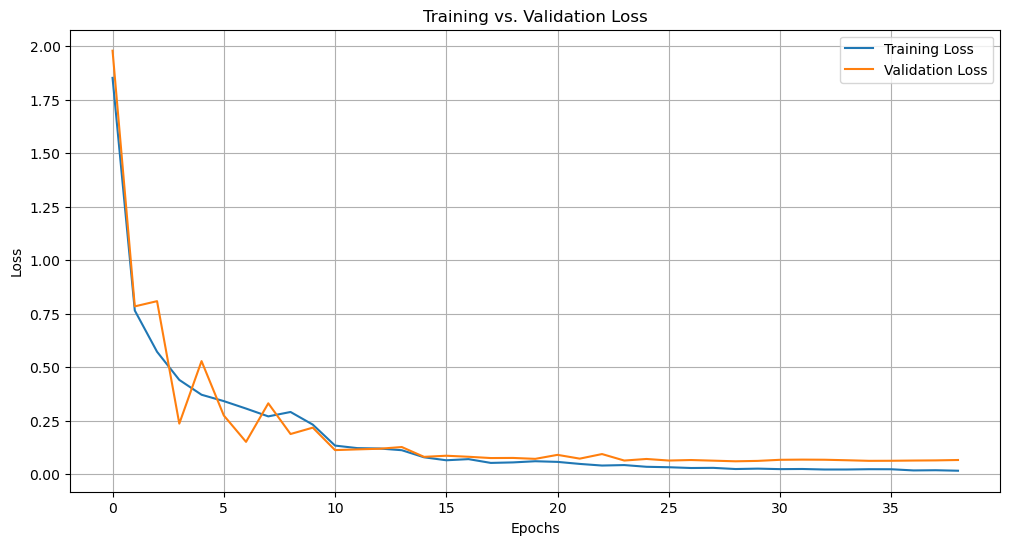

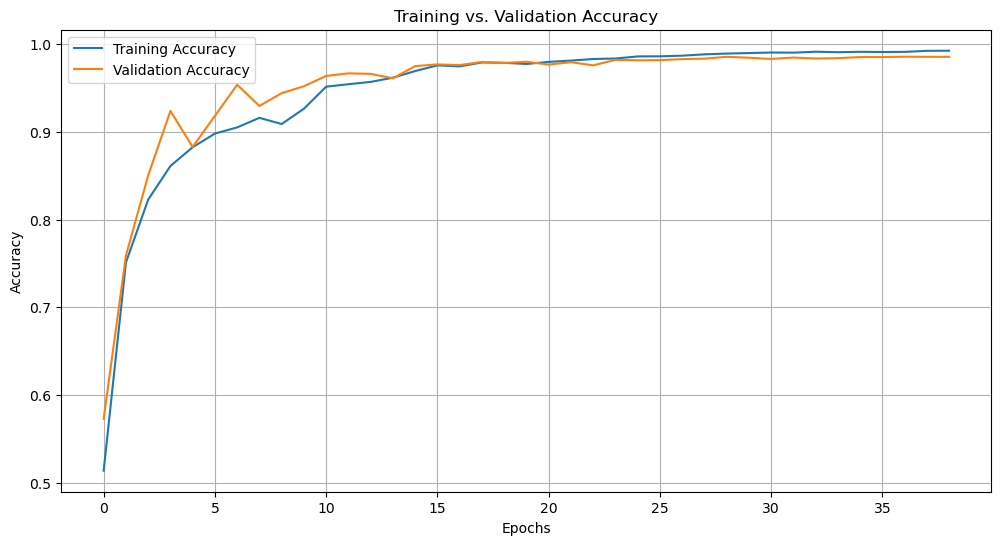

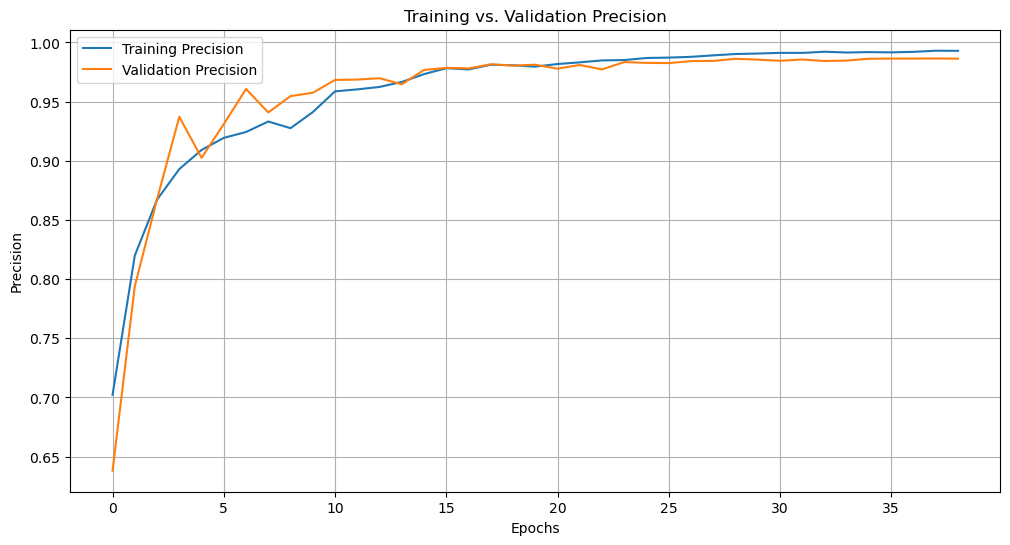

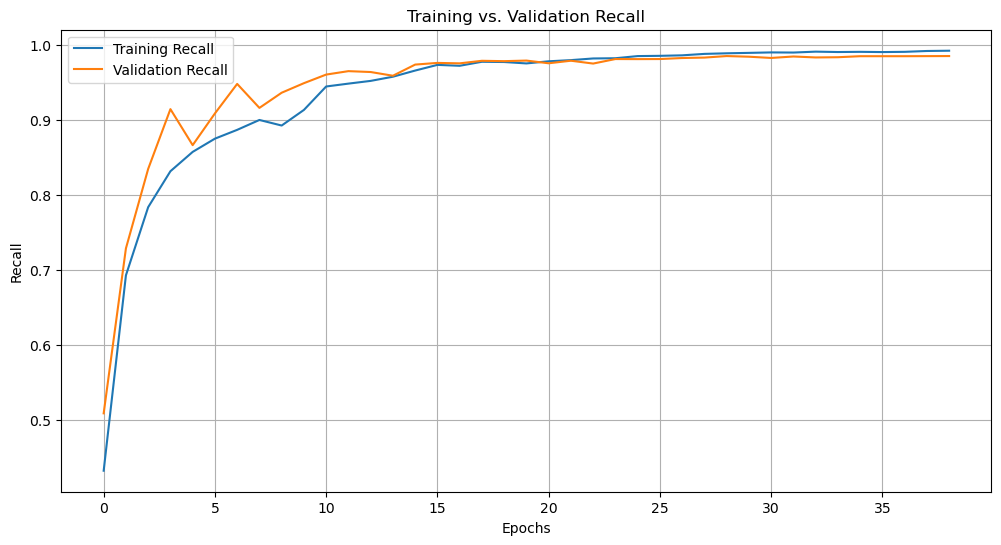

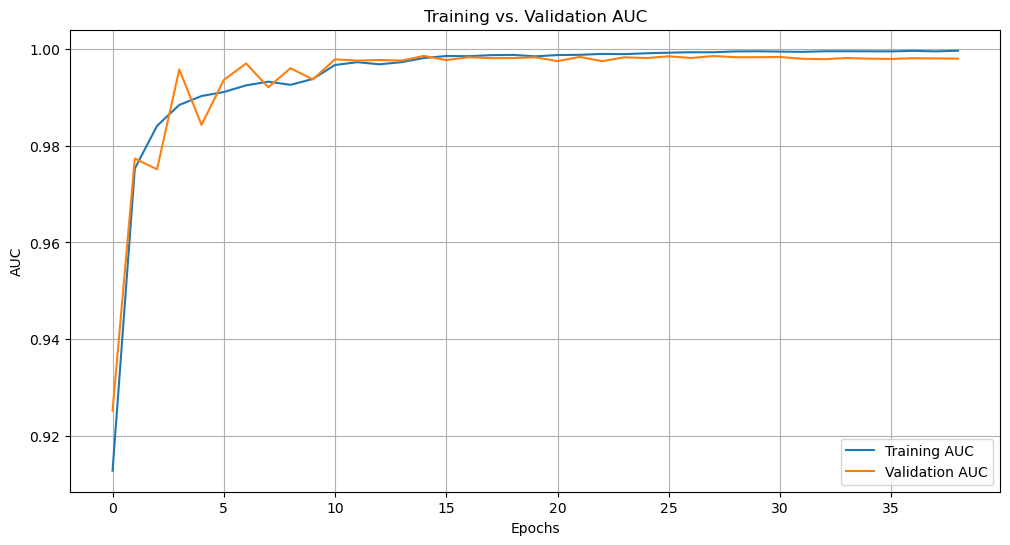

In [30]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history_resnet_disease.history['loss'], label='Training Loss')
plt.plot(history_resnet_disease.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_resnet_disease.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_disease.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Precision
plt.figure(figsize=(12, 6))
plt.plot(history_resnet_disease.history['precision_10'], label='Training Precision')
plt.plot(history_resnet_disease.history['val_precision_10'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training vs. Validation Precision')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Recall
plt.figure(figsize=(12, 6))
plt.plot(history_resnet_disease.history['recall_10'], label='Training Recall')
plt.plot(history_resnet_disease.history['val_recall_10'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training vs. Validation Recall')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation AUC
plt.figure(figsize=(12, 6))
plt.plot(history_resnet_disease.history['auc_10'], label='Training AUC')
plt.plot(history_resnet_disease.history['val_auc_10'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid()
plt.show()


### Densenet121

In [31]:
from tensorflow.keras.applications import DenseNet121  # Use a smaller model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC

# Load DenseNet121 with pre-trained ImageNet weights (using a smaller model)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the initial layers to reduce memory usage
for layer in base_model.layers[:300]:  # Freeze more layers to reduce computational load
    layer.trainable = False

# Custom layers on top of DenseNet121
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(classes_list_disease), activation='softmax')(x)

# Define and compile the DenseNet121 model for disease classification
densenet_disease_model = Model(inputs=base_model.input, outputs=output)
densenet_disease_model.compile(optimizer=Adam(learning_rate=1e-3),
                               loss='categorical_crossentropy',
                               metrics=['accuracy', Precision(), Recall(), AUC()])

# Callbacks for DenseNet121 (Disease Classification)
checkpoint_densenet_disease = ModelCheckpoint(filepath=r'C:\Users\bheja\OneDrive\Desktop\models\densenet121_disease.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr_disease = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop_disease = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the DenseNet121 model with a reduced batch size
history_densenet_disease = densenet_disease_model.fit(
    train_generator_disease,
    epochs=50,
    validation_data=test_seen_generator_disease,
    #batch_size=8,  # Reduce the batch size if "Resource exhausted"
    class_weight=class_weights_disease_dict,
    callbacks=[reduce_lr_disease, early_stop_disease, checkpoint_densenet_disease]
)


Epoch 1/50
1219/1219 [==============================] - ETA: 0s - loss: 0.7182 - accuracy: 0.7970 - precision_11: 0.8533 - recall_11: 0.7596 - auc_11: 0.9777
Epoch 1: val_loss improved from inf to 0.41235, saving model to C:\Users\bheja\OneDrive\Desktop\models\densenet121_disease.h5
1219/1219 [==============================] - 650s 521ms/step - loss: 0.7182 - accuracy: 0.7970 - precision_11: 0.8533 - recall_11: 0.7596 - auc_11: 0.9777 - val_loss: 0.4124 - val_accuracy: 0.9075 - val_precision_11: 0.9218 - val_recall_11: 0.8944 - val_auc_11: 0.9893 - lr: 0.0010
Epoch 2/50
1219/1219 [==============================] - ETA: 0s - loss: 0.3109 - accuracy: 0.9039 - precision_11: 0.9249 - recall_11: 0.8852 - auc_11: 0.9917
Epoch 2: val_loss improved from 0.41235 to 0.16726, saving model to C:\Users\bheja\OneDrive\Desktop\models\densenet121_disease.h5
1219/1219 [==============================] - 548s 449ms/step - loss: 0.3109 - accuracy: 0.9039 - precision_11: 0.9249 - recall_11: 0.8852 - auc_11

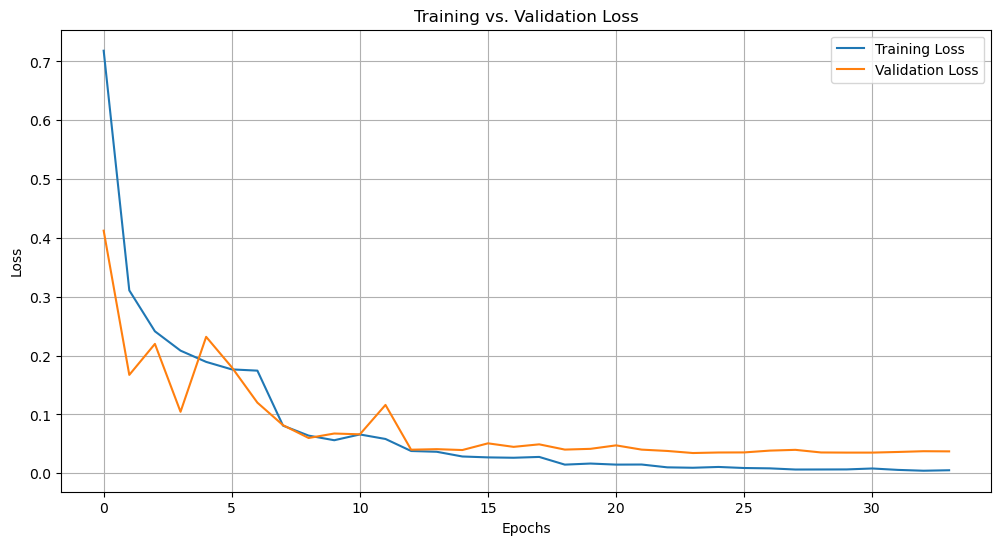

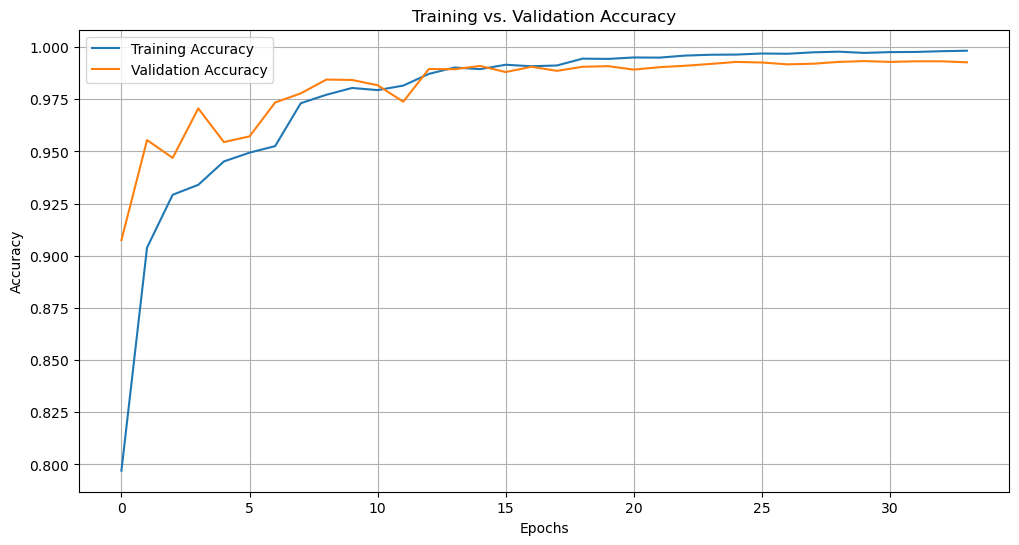

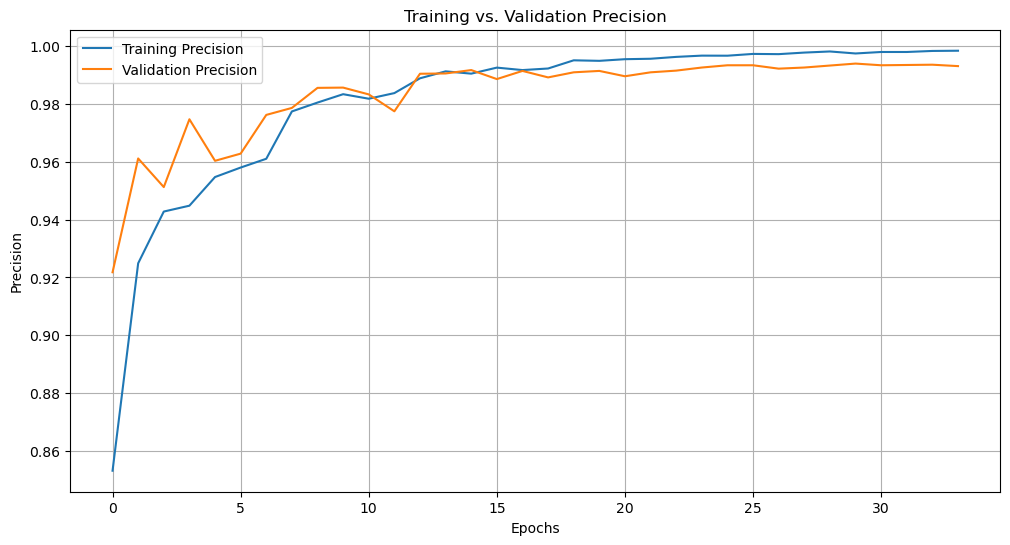

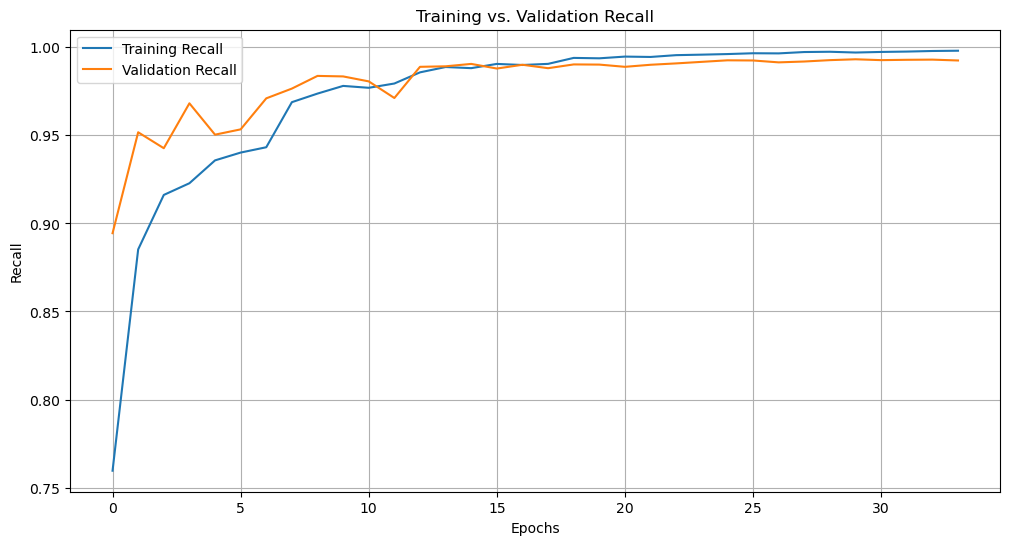

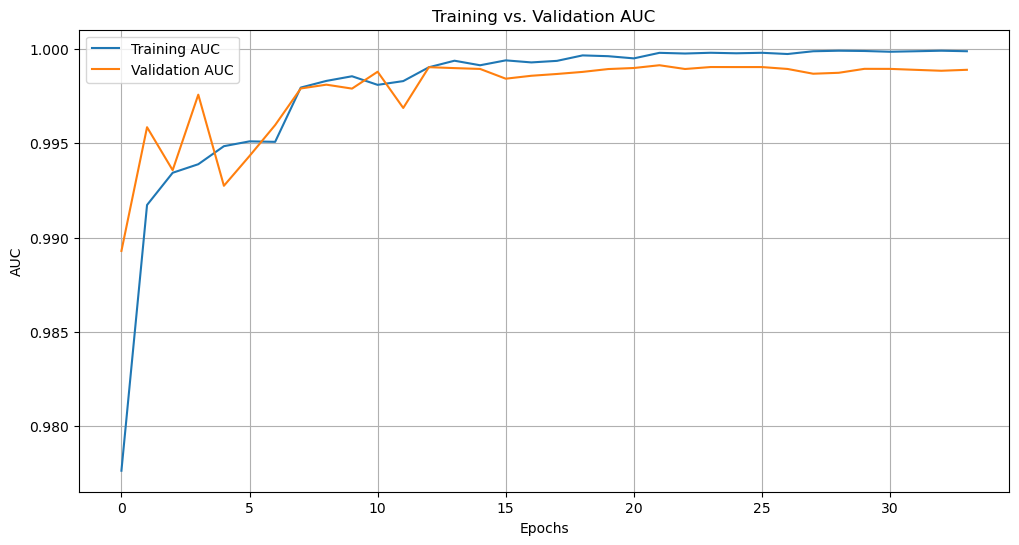

In [34]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history_densenet_disease.history['loss'], label='Training Loss')
plt.plot(history_densenet_disease.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_densenet_disease.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet_disease.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Precision
plt.figure(figsize=(12, 6))
plt.plot(history_densenet_disease.history['precision_11'], label='Training Precision')
plt.plot(history_densenet_disease.history['val_precision_11'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training vs. Validation Precision')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation Recall
plt.figure(figsize=(12, 6))
plt.plot(history_densenet_disease.history['recall_11'], label='Training Recall')
plt.plot(history_densenet_disease.history['val_recall_11'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training vs. Validation Recall')
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Validation AUC
plt.figure(figsize=(12, 6))
plt.plot(history_densenet_disease.history['auc_11'], label='Training AUC')
plt.plot(history_densenet_disease.history['val_auc_11'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs. Validation AUC')
plt.legend()
plt.grid()
plt.show()


### EfficientNet ---- Did not run (Resource exhausted) -- laptop gpu rtx 3050

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC

# Load EfficientNetB0 with pre-trained ImageNet weights for disease classification
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Custom layers on top of EfficientNetB0 for disease classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(classes_list_disease), activation='softmax')(x)  # Updated to use classes_list_disease

# Define and compile the EfficientNetB0 model for disease classification
efficientnet_model_disease = Model(inputs=base_model.input, outputs=output)
efficientnet_model_disease.compile(optimizer=Adam(learning_rate=1e-3),
                                   loss='categorical_crossentropy',
                                   metrics=['accuracy', Precision(), Recall(), AUC()])

# Callbacks for EfficientNetB0 disease model
checkpoint_efficientnet_disease = ModelCheckpoint(filepath=r'C:\Users\bheja\OneDrive\Desktop\models\efficientb0_disease.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr_disease = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop_disease = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the EfficientNetB0 model for disease classification
history_efficientnet_disease = efficientnet_model_disease.fit(
    train_generator_disease,
    epochs=50,
    validation_data=test_seen_generator_disease,
    class_weight=class_weights_disease_dict,
    callbacks=[reduce_lr_disease, early_stop_disease, checkpoint_efficientnet_disease]
)

